# Logistic model  

In [3]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.training import train_deepmod, train_mse
from deepymod_torch.library_functions import library_1D_in

from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

%load_ext autoreload
%autoreload 2

In [10]:
def dU_dt(U, t):
    # Here U is a vector such that u=U[0] and v=U[1]. This function should return [u, v]' 
    # The ODE we solve here is u' = u*v and v' = -0.2v
    return [U[1]*U[0], -0.2*U[1]]
U0 = [2.5, 0.4]
ts = np.linspace(0, 20, 500)
Y = odeint(dU_dt_sin, U0, ts)
T = ts.reshape(-1,1)

In [11]:
T_rs = T
Y_rs = Y/np.max(np.abs(Y),axis=0)

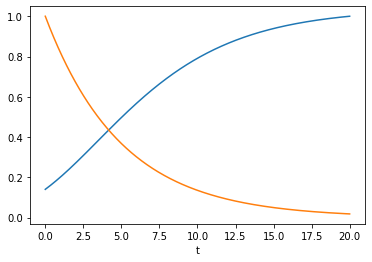

In [12]:
fig, ax = plt.subplots()
ax.plot(T_rs, Y_rs[:,0])
ax.plot(T_rs, Y_rs[:,1])
ax.set_xlabel('t')

plt.show()

In [13]:
number_of_samples = 100

idx = np.random.permutation(Y.shape[0])
X_train = torch.tensor(T_rs[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(Y_rs[idx, :][:number_of_samples], dtype=torch.float32)

In [14]:
print(X_train.shape, y_train.shape)

torch.Size([100, 1]) torch.Size([100, 2])


# Setup a custom library

In [15]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce

Here we show an example where we create a custom library. $\theta$ in this case containe $[1,u,v, u*v]$ to showcase that non-linear terms can easily be added to the library

In [17]:
def library_non_linear_ODE(input, poly_order, diff_order):
    
    prediction, data = input
    samples = prediction.shape[0]
    
    # Construct the theta matrix
    C = torch.ones_like(prediction[:,0]).view(samples, -1)
    u = prediction[:,0].view(samples, -1)
    v = prediction[:,1].view(samples, -1)
    theta = torch.cat((C, u, v, u*v),dim=1)

    # Construct a list of time_derivatives 
    time_deriv_list = []
    for output in torch.arange(prediction.shape[1]):
        dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True)[0]
        time_deriv = dy[:, 0:1]
        time_deriv_list.append(time_deriv)
        
    return time_deriv_list, theta


## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [30]:
## Running DeepMoD
config = {'n_in': 1, 'hidden_dims': [20,20,20,20,20], 'n_out': 2, 'library_function': library_non_linear_ODE, 'library_args':{'poly_order': 1, 'diff_order': 0}}

Now we instantiate the model. Note that the learning rate of the coefficient vector can typically be set up to an order of magnitude higher to speed up convergence without loss in accuracy

In [31]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}])

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [32]:
train_deepmod(model, X_train, y_train, optimizer, 50000, {'l1': 1e-4})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
      37200     74.40%               0s   2.02e-04   1.27e-06   2.50e-06   1.98e-04 

KeyboardInterrupt: 

In [21]:
solution = model(X_train)[0].detach().numpy()

In [22]:
np.max(np.abs(Y),axis=0)

array([17.80820748,  0.4       ])

In [27]:
print(model.fit.coeff_vector[0],model.fit.coeff_vector[1])

Parameter containing:
tensor([[-4.7004e-04],
        [ 3.1881e-04],
        [ 7.4061e-04],
        [ 3.8119e-01]], requires_grad=True) Parameter containing:
tensor([[-1.3845e-04],
        [-1.7569e-04],
        [-1.9776e-01],
        [-1.9382e-04]], requires_grad=True)


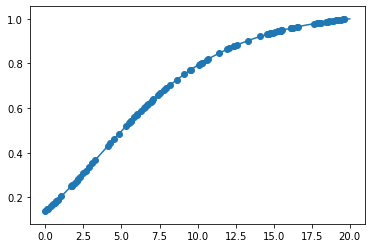

In [28]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,0])
plt.plot(T_rs,Y_rs[:,0])

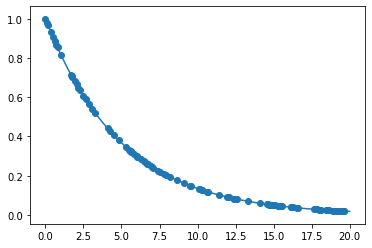

In [29]:
plt.scatter(X_train.detach().numpy().squeeze(),solution[:,1])
plt.plot(T_rs,Y_rs[:,1])